# Section 3.2 — Confidence intervals

This notebook contains the code examples from [Section 3.2 Confidence intervals]() of the **No Bullshit Guide to Statistics**.


#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot helper functions
from plot_helpers import plot_pdf
from plot_helpers import savefigure

In [3]:
# Figures setup
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc={'figure.figsize': (5,2)},
)
blue, orange  = sns.color_palette()[0], sns.color_palette()[1]

DESTDIR = "figures/stats/confidence_intervals"

%config InlineBackend.figure_format = 'retina'

In [4]:
# set random seed for repeatability
np.random.seed(42)

$\def\stderr#1{\mathbf{se}_{#1}}$
$\def\stderrhat#1{\hat{\mathbf{se}}_{#1}}$
$\newcommand{\Mean}{\textbf{Mean}}$
$\newcommand{\Var}{\textbf{Var}}$
$\newcommand{\Std}{\textbf{Std}}$
$\newcommand{\Freq}{\textbf{Freq}}$
$\newcommand{\RelFreq}{\textbf{RelFreq}}$
$\newcommand{\DMeans}{\textbf{DMeans}}$
$\newcommand{\Prop}{\textbf{Prop}}$
$\newcommand{\DProps}{\textbf{DProps}}$


(this cell contains the macro definitions $\stderr{}$, $\stderrhat{}$, $\Mean$, ...)

## Definitions



In [5]:
def mean(sample):
    return sum(sample) / len(sample)

def var(sample):
    xbar = mean(sample)
    sumsqdevs = sum([(xi-xbar)**2 for xi in sample])
    return sumsqdevs / (len(sample)-1)

def dmeans(xsample, ysample):
    """
    Compute the difference between group means of the samples.
    """
    dhat = mean(xsample) - mean(ysample)
    return dhat

In [6]:
# simulation based sampling distributoin
def gen_sampling_dist(rv, statfunc, n, N=10000):
    stats = []
    for i in range(0, N):
        sample = rv.rvs(n)
        stat = statfunc(sample)
        stats.append(stat)
    return stats

In [7]:
from scipy.stats import norm
mu = 1000
sigma = 100
rvN = norm(mu, sigma)

np.random.seed(47)
nsample20 = rvN.rvs(20)
nsample20

array([ 915.19905242, 1130.59063579, 1092.42079662, 1064.04118012,
        894.52630171, 1179.77607151,  898.72132495, 1082.36233243,
        970.53496466,  940.75294285,  860.62729413, 1110.41796717,
        906.76597141,  905.68435632, 1043.66062317, 1079.495827  ,
       1071.95331527, 1008.76622566,  867.72515937, 1005.17939788])

## Confidence intervals

$$
 CI = \left[
         F^{-1}\big(\tfrac{\alpha}{2}\big),
         F^{-1}\big(1-\tfrac{\alpha}{2}\big)
      \right]
$$

Saved figure to figures/stats/confidence_intervals/confidence_intervals_mean_N50n20_normal_mu1000_sigma100.pdf
Saved figure to figures/stats/confidence_intervals/confidence_intervals_mean_N50n20_normal_mu1000_sigma100.png


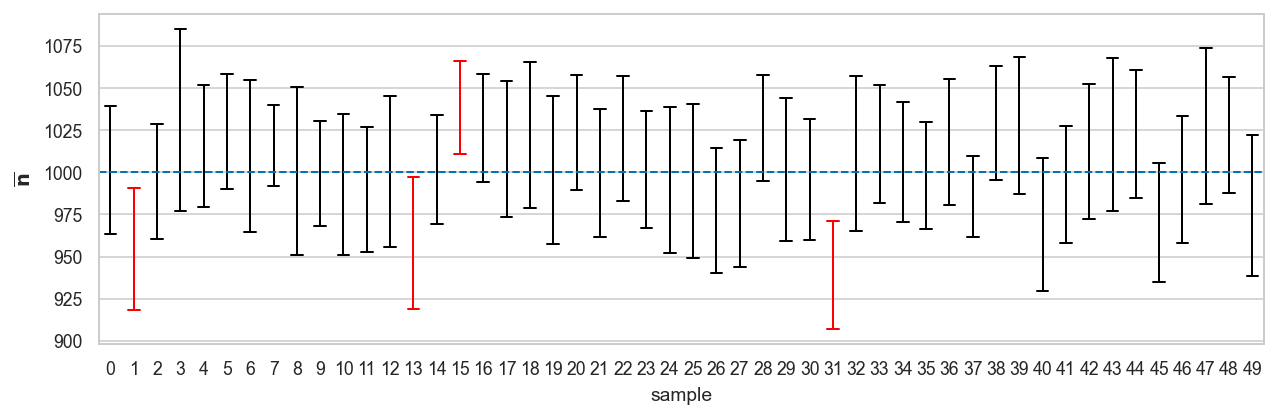

In [8]:
filename = os.path.join(DESTDIR, "confidence_intervals_mean_N50n20_normal_mu1000_sigma100.pdf")

from scipy.stats import norm
from plot_helpers import gen_samples
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
palette = sns.color_palette(palette=["#ff0000", "#000000"])


N = 50
n = 20

# Generate N=50 samples of size n=20 from a normal dist
rvN = norm(1000,100)
np.random.seed(47)
samples_df = gen_samples(rvN, n=n, N=N)
samples_df.columns = range(0,N)
df2 = samples_df.melt(var_name="sample", value_name="n")

def confint(data):
    """
    Compute 90% confidence interval.
    Note:  1.729 = tdist(19).ppf(0.95)
    """
    n = len(data)
    mean = data.mean()
    std = data.std(ddof=1)
    se = std/np.sqrt(n)
    return [mean - 1.729*se, mean + 1.729*se]

# Add new column to indicate if CI contains mean or not
for sidx in range(0,N):
    sample = df2[df2["sample"]==sidx]["n"].values
    C_L, C_U = confint(sample)
    if C_L <= 1000 and 1000 <= C_U:
        outcome = 1  # includes 1000
    else:
        outcome = 0  # doesn't include 1000
    df2.loc[df2["sample"]==sidx,"success"] = outcome


with warnings.catch_warnings(), plt.rc_context({"figure.figsize":(9,3)}):
    warnings.filterwarnings('ignore', category=UserWarning)    
    ax = sns.pointplot(x="sample", y="n", hue="success", data=df2,
                       errorbar=confint, palette=palette,
                       join=False, capsize=0.5, markers=" ", errwidth=1)
    ax.set_ylabel("$\overline{\mathbf{n}}$")
    ax.axhline(y=1000, color='b', label='Mean', linestyle='--', linewidth=1)
    ax.legend([],[], frameon=False)
    savefigure(ax, filename)

### Analytical approximations

#### Confidence interval for the sample mean

In [9]:
n = 20
xbar = mean(nsample20)
xstd = np.std(nsample20, ddof=1)
sehat = xstd / np.sqrt(n)

from scipy.stats import t as tdist
rvT = tdist(n-1)

t_05 = abs(rvT.ppf(0.05))
t_95 = abs(rvT.ppf(0.95))
CI_mu_tdist = [xbar - t_05*sehat, xbar + t_95*sehat]
CI_mu_tdist

[963.6268617138455, 1039.2933123335304]

In [10]:
# ALT1.
from scipy.stats import t as tdist
tdist.interval(0.9, df=n-1, loc=xbar, scale=sehat)

(963.6268617138455, 1039.2933123335304)

In [11]:
# ALT2.
import statsmodels.stats.api as sms
sms.DescrStatsW(nsample20).tconfint_mean(alpha=0.1)

(963.6268617138455, 1039.2933123335304)

#### Confidence interval for the sample variance

In [12]:
n = 20
xvar = np.var(nsample20, ddof=1)

from scipy.stats import chi2
rvX2 = chi2(n-1)

x2_05 = rvX2.ppf(0.05)
x2_95 = rvX2.ppf(0.95)
CI_sigma2_tdist = [(n-1)*xvar/x2_95, (n-1)*xvar/x2_05]
CI_sigma2_tdist

[6035.031718920199, 17981.3094693008]

### Bootstrap confidence intervals

In [13]:
def bootstrap_stat(sample, statfunc, B=5000):
    """
    Compute the sampling dist. of the `statfunc` estimator
    from `B` bootstrap samples generated from `sample`.
    """
    n = len(sample)
    bstats = []
    for i in range(0, B):
        bsample = np.random.choice(sample, n, replace=True)
        bstat = statfunc(bsample)
        bstats.append(bstat)
    return bstats

#### Confidence interval for the sample mean

In [14]:
np.random.seed(48)
nbars_boot = bootstrap_stat(nsample20, statfunc=mean)
CI_mu_boot = [np.percentile(nbars_boot,5),
              np.percentile(nbars_boot,95)]
CI_mu_boot

[966.9101312640927, 1035.6221138821832]

In [15]:
# true sampling distribuiton (simulation)
nbars = gen_sampling_dist(rvN, statfunc=mean, n=20)
[np.percentile(nbars,5),
 np.percentile(nbars,95)]

[963.1651448677608, 1037.2236488759474]

#### Confidence interval for the sample variance

In [16]:
np.random.seed(48)
nvars_boot = bootstrap_stat(nsample20, statfunc=var)
CI_sigma2_boot = [np.percentile(nvars_boot,5),
                 np.percentile(nvars_boot,95)]
CI_sigma2_boot

[6266.960681769309, 12339.2572499587]

In [17]:
# true
nvars = gen_sampling_dist(rvN, statfunc=var, n=20)
[np.percentile(nvars,5),
 np.percentile(nvars,95)]

[5333.12751396754, 15931.562101382808]

#### Confidence interval for the sample median (optional)

In [18]:
nmedians_boot = bootstrap_stat(nsample20, statfunc=np.median)
CI_median_boot = [np.percentile(nmedians_boot,5),
                  np.percentile(nmedians_boot,95)]
CI_median_boot

[915.199052423386, 1071.9533152748243]

In [19]:
# true
nmedians = gen_sampling_dist(rvN, statfunc=np.median, n=20)
[np.percentile(nmedians,5),
 np.percentile(nmedians,95)]

[956.1837483787382, 1044.358290198796]

#### Confidence interval for the 90th percentile (optional)

In [20]:
def ninetypctile(sample):
    return np.percentile(sample, 90)

In [21]:
ninetypctiles_boot = bootstrap_stat(nsample20, statfunc=ninetypctile)
CI_ninetypctile_boot = [np.percentile(ninetypctiles_boot,5),
                        np.percentile(ninetypctiles_boot,95)]
CI_ninetypctile_boot

[1079.7824775466474, 1179.7760715125444]

In [22]:
# true
ninetypctiles = gen_sampling_dist(rvN, statfunc=ninetypctile, n=20)
[np.percentile(ninetypctiles,5),
 np.percentile(ninetypctiles,95)]

[1061.4381044914307, 1175.6365583470213]

## Explanations

## Discussion